# Part 3: Topic Modeling

This notebook will serve to format the tweet data (cleaned in the `data_cleaning.ipynb` notebook) into a tf-idf structure and then perform topic modeling via NMF and LDA.

### General setup

In [1]:
# Import packages
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Set theme for creating visualizations

# Set text sizes
title_size = 22
label_size = 16
tick_text_size = 12

# Set background and text colors
background_color = '#F7F7F4'
text_color = 'black'

# Set options of colors for use in plotting
color1 = "#9FB881"  # (dark green)
color2 = "#B89A81"  # (brown)
color3 = "#2E4057"  # (charcoal)
color4 = "#cfbaa9"  # (light brown)
color5 = "#806248"  # (dark brown)
color6 = "#B8B681"  # (dark tan)
color7 = "#D19C1D"  # (gold)
color8 = "#969966"  # (army green)

# Set theme for creating visualizations
plt.rcParams.update({
                     'axes.edgecolor': 'white',
                     'axes.facecolor': background_color,
                     'axes.grid': True,
                     'axes.labelcolor': text_color,
                     'axes.titlesize': title_size,
                     'axes.labelsize': label_size,
                     'figure.facecolor': background_color,
                     'text.color': text_color,
                     'xtick.color': text_color,
                     'xtick.labelsize' : tick_text_size,
                     'ytick.color': text_color,
                     'ytick.labelsize' : tick_text_size,
                     })

### Prepare data

In [3]:
# Read in data
data = pd.read_csv('./cleaned_tweet_data.csv')

# View first few rows of data
data.head(2)

,created_at,text,hashtags,user_mention_ids,user_mention_screen_names,retweet_count,favorite_count,user_id,user_screen_name,user_name,user_location,user_friends_count,user_followers_count,user_favourites_count,user_verfied,user_statuses_count,topic,text_clean,text_clean_noStop,text_clean_noStop_noSearch
0,2022-10-18 00:00:00,Sharp words on guns in Shane Hazel to Stacey A...,['gagovdebate'],[],[],5,24,25282846,SimonesNews,Simone Sebastian,Washington DC,3110,5830,1445,True,4400,abrams,sharp words on guns in shane hazel to stacey ...,sharp words guns shane hazel stacey abrams kee...,sharp words guns shane hazel keep going back g...
1,2022-10-18 00:00:01,Stacey Abrams won tonight. She kept to the fac...,[],[],[],0,6,1312393604439183361,nching0,Thee Lost Edges of Candace 🪥,"34.2073° N, 84.1402° W",922,752,101529,False,61963,abrams,stacey abrams won tonight she kept to the ...,stacey abrams tonight kept facts answered ques...,tonight kept facts answered questions math poi...


In [4]:
# Subset data to keep only the cleaned text data
data = data[['created_at', 'text', 'text_clean_noStop_noSearch', 'topic']]

# Rename column
data.rename(columns={'text_clean_noStop_noSearch':'text_clean'}, inplace=True)

# See first few rows of updated dataframe
data.head(10)

,created_at,text,text_clean,topic
0,2022-10-18 00:00:00,Sharp words on guns in Shane Hazel to Stacey A...,sharp words guns shane hazel keep going back g...,abrams
1,2022-10-18 00:00:01,Stacey Abrams won tonight. She kept to the fac...,tonight kept facts answered questions math poi...,abrams
2,2022-10-18 00:00:01,"Why did Joe Rogan send his little brother, Sha...",joe rogan send little brother shane interrupt ...,abrams
3,2022-10-18 00:00:08,Viral handbag designer and EBONY Power100 Styl...,viral handbag designer ebony power style curat...,abrams
4,2022-10-18 00:00:11,THE MOST DANGEROUS THING FACING GEORGIA IS 4 M...,dangerous thing facing years wow,kemp
5,2022-10-18 00:00:16,Mrs. Abrams showed the same poise and skill as...,mrs showed poise skill kbj earlier year face g...,kemp
6,2022-10-18 00:00:16,Thanks for the link BDD! Who was the other guy...,thanks link bdd guy seems lot like republicans...,abrams
7,2022-10-18 00:00:19,"Stacey Abrams: ""The most dangerous thing facin...",dangerous thing facing four years,"abrams, kemp"
8,2022-10-18 00:00:23,"Stacey Abrams is on ,",NaN,abrams
9,2022-10-18 00:00:24,Yeah . But they dont have to . If he told them...,yeah dont told vote still would hes got black ...,kemp


In [5]:
# Remove any tweets that have no words after cleaning + removing stopwords + removing search words
data = data[~data['text_clean'].isna()]

# View first few rows of text and cleaned text columns
data.head(10)

,created_at,text,text_clean,topic
0,2022-10-18 00:00:00,Sharp words on guns in Shane Hazel to Stacey A...,sharp words guns shane hazel keep going back g...,abrams
1,2022-10-18 00:00:01,Stacey Abrams won tonight. She kept to the fac...,tonight kept facts answered questions math poi...,abrams
2,2022-10-18 00:00:01,"Why did Joe Rogan send his little brother, Sha...",joe rogan send little brother shane interrupt ...,abrams
3,2022-10-18 00:00:08,Viral handbag designer and EBONY Power100 Styl...,viral handbag designer ebony power style curat...,abrams
4,2022-10-18 00:00:11,THE MOST DANGEROUS THING FACING GEORGIA IS 4 M...,dangerous thing facing years wow,kemp
5,2022-10-18 00:00:16,Mrs. Abrams showed the same poise and skill as...,mrs showed poise skill kbj earlier year face g...,kemp
6,2022-10-18 00:00:16,Thanks for the link BDD! Who was the other guy...,thanks link bdd guy seems lot like republicans...,abrams
7,2022-10-18 00:00:19,"Stacey Abrams: ""The most dangerous thing facin...",dangerous thing facing four years,"abrams, kemp"
9,2022-10-18 00:00:24,Yeah . But they dont have to . If he told them...,yeah dont told vote still would hes got black ...,kemp
10,2022-10-18 00:00:25,"Well Done Stacey Abrams!Facts, Truth, and Inte...",well done facts truth integrity debated every ...,abrams


### Split tweets into those about Abrams and those about Kemp

In [6]:
data_abrams = data[data['topic'].str.contains('abrams')]
data_kemp = data[data['topic'].str.contains('kemp')]

### Convert cleaned text to vector form

In [7]:
### Get number of words (vocab size) for each dataset 

# All Tweets
vocab_size_all = len(set([word for tweet in data['text_clean'] for word in tweet.split(' ')]))
print('Number of Words - All Tweets:  ', vocab_size_all)

# Abrams Tweets
vocab_size_abrams = len(set([word for tweet in data_abrams['text_clean'] for word in tweet.split(' ')]))
print('Number of Words - Abrams Tweets:', vocab_size_abrams)

# Kemp Tweets
vocab_size_kemp = len(set([word for tweet in data_kemp['text_clean'] for word in tweet.split(' ')]))
print('Number of Words - Kemp Tweets:  ', vocab_size_kemp)

Number of Words - All Tweets:   27892
Number of Words - Abrams Tweets: 21927
Number of Words - Kemp Tweets:   14461


In [8]:
### Transform text to vector form - term frequency matrix

# All Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_all = CountVectorizer(max_features=vocab_size_all, max_df=0.95, min_df=0.005, stop_words='english')
tf_all = tf_vectorizer_all.fit_transform(data['text_clean'])
tf_feature_names_all = tf_vectorizer_all.get_feature_names()

# Abrams Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_abrams = CountVectorizer(max_features=vocab_size_abrams, max_df=0.95, min_df=0.005, stop_words='english')
tf_abrams = tf_vectorizer_abrams.fit_transform(data_abrams['text_clean'])
tf_feature_names_abrams = tf_vectorizer_abrams.get_feature_names()

# Kemp Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_kemp = CountVectorizer(max_features=vocab_size_kemp, max_df=0.95, min_df=0.005, stop_words='english')
tf_kemp = tf_vectorizer_kemp.fit_transform(data_kemp['text_clean'])
tf_feature_names_kemp = tf_vectorizer_kemp.get_feature_names()

/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
### Get text into tf-idf form

# All Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_all = TfidfVectorizer(max_features=vocab_size_all, max_df=0.95, stop_words='english')
tfidf_all = tfidf_vectorizer_all.fit_transform(data['text_clean'])
tfidf_feature_names_all = tfidf_vectorizer_all.get_feature_names()

# Abrams Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_abrams = TfidfVectorizer(max_features=vocab_size_abrams, max_df=0.95, stop_words='english')
tfidf_abrams = tfidf_vectorizer_abrams.fit_transform(data_abrams['text_clean'])
tfidf_feature_names_abrams = tfidf_vectorizer_abrams.get_feature_names()

# Kemp Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_kemp = TfidfVectorizer(max_features=vocab_size_kemp, max_df=0.95, stop_words='english')
tfidf_kemp = tfidf_vectorizer_kemp.fit_transform(data_kemp['text_clean'])
tfidf_feature_names_kemp = tfidf_vectorizer_kemp.get_feature_names()

In [10]:
# Confirm feature names (words) from tf and tfidf are the same
print('All Tweets:   ', [n for n in tf_feature_names_all if n not in tfidf_feature_names_all])
print('Abrams Tweets:', [n for n in tf_feature_names_abrams if n not in tfidf_feature_names_abrams])
print('Kemp Tweets:  ', [n for n in tf_feature_names_kemp if n not in tfidf_feature_names_kemp])

All Tweets:    []
Abrams Tweets: []
Kemp Tweets:   []


### Topic Modeling

In [11]:
# Set number of topics to model
num_topics = 6

In [12]:
# Define method to visualize words for each topic
# Note/Reference: this code is adapted from code provided by the ANLY 580 professors in Lab assignment #4
def plot_top_words(model, feature_names, n_top_words, title, save_as, share_x):
    plt.clf()
    cols = 3
    rows = num_topics // cols + num_topics % cols
    if share_x:
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=True)
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color1)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': label_size}
                     )
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=tick_text_size)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=title_size)
    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.4)
    plt.savefig('../Visualizations/'+save_as+'.png')
    plt.show()

##### **NMF**

In [13]:
# Instantiate the model
mod_nmf_abrams = NMF(n_components=num_topics)
mod_nmf_kemp = NMF(n_components=num_topics)

# Fit-Transform the model to the data
feat_nmf_abrams = mod_nmf_abrams.fit_transform(tfidf_abrams)
feat_nmf_kemp = mod_nmf_kemp.fit_transform(tfidf_kemp)

# See shape of features
print('NMF Features Shape - Abrams:', feat_nmf_abrams.shape)
print('NMF Features Shape - Kemp:', feat_nmf_kemp.shape)

/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF Features Shape - Abrams: (35119, 6)
NMF Features Shape - Kemp: (14664, 6)


<Figure size 640x480 with 0 Axes>

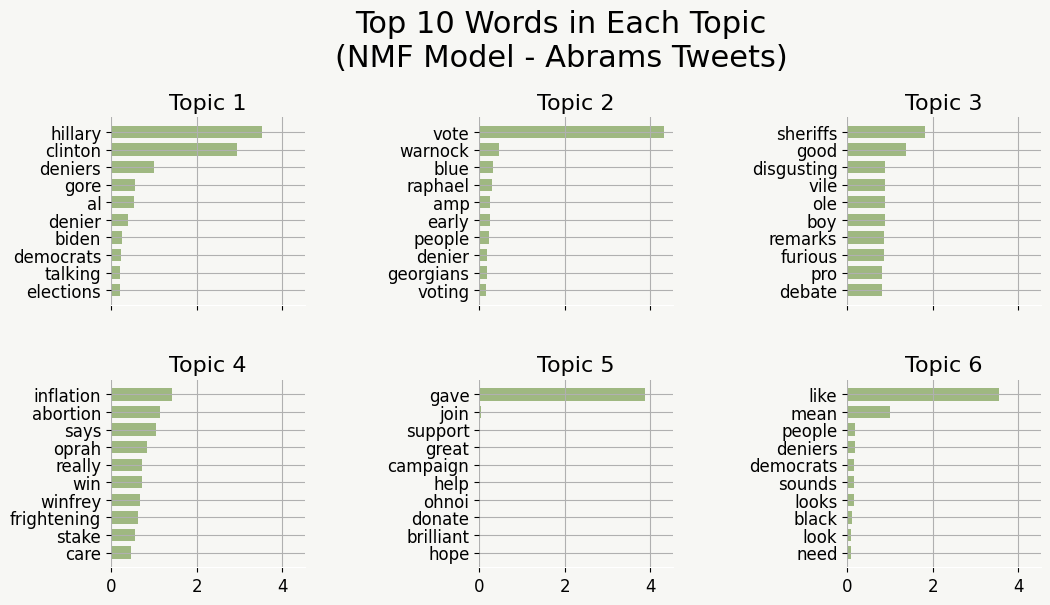

In [14]:
# Plot top 10 words of each topic - NMF Model - Abrams tweets (share x-axis)
plot_top_words(model=mod_nmf_abrams, 
               feature_names=tfidf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Abrams Tweets)', 
               save_as='topic_mod_nmf_abrams_sharexYES',
               share_x=True)

<Figure size 640x480 with 0 Axes>

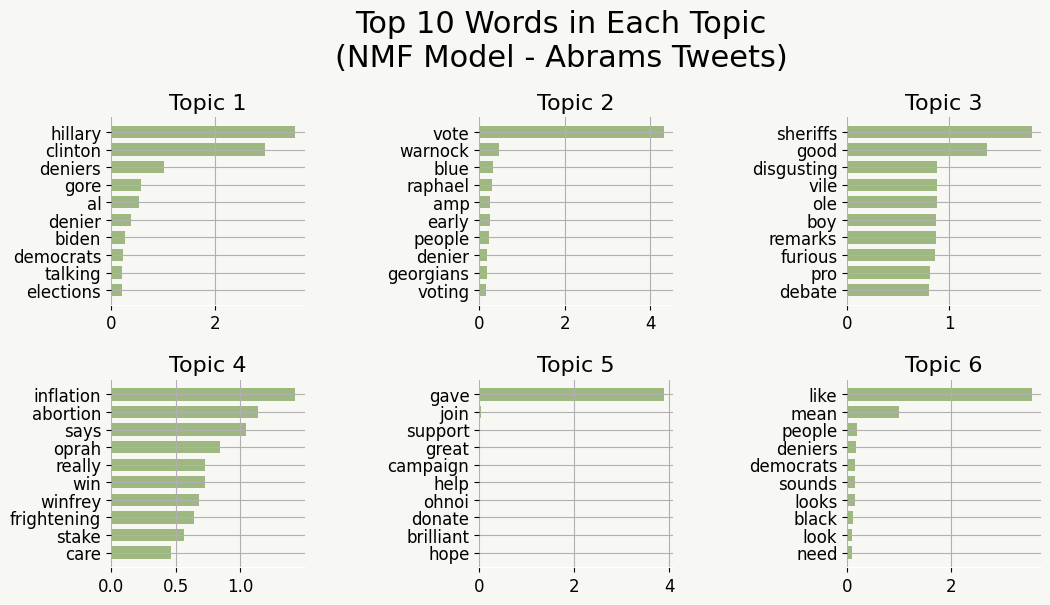

In [15]:
# Plot top 10 words of each topic - NMF Model - Abrams tweets (don't share x-axis)
plot_top_words(model=mod_nmf_abrams, 
               feature_names=tfidf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Abrams Tweets)', 
               save_as='topic_mod_nmf_abrams_sharexNO',
               share_x=False)

<Figure size 640x480 with 0 Axes>

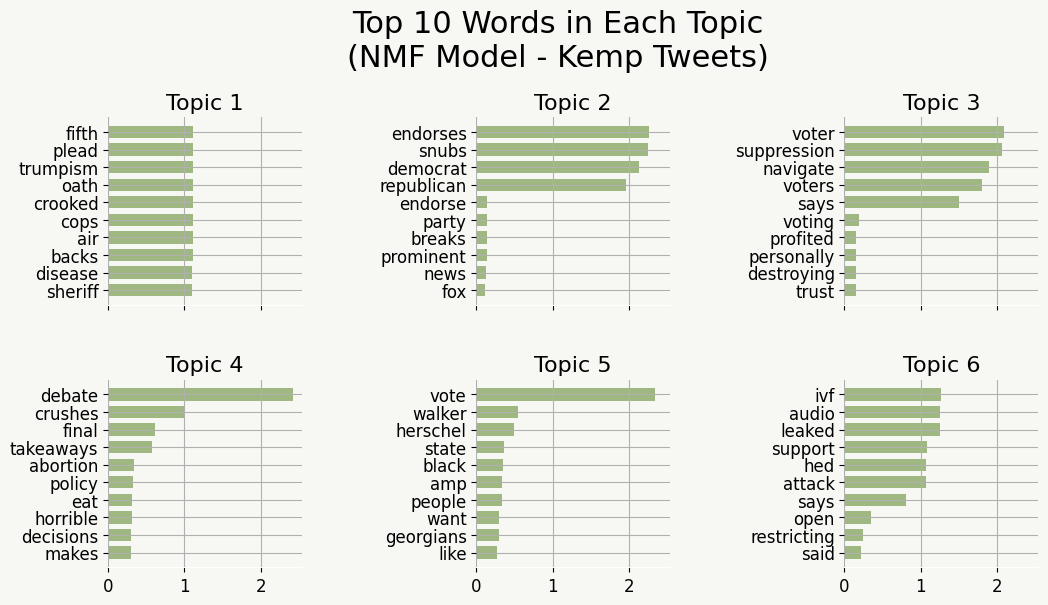

In [16]:
# Plot top 10 words of each topic - NMF Model - Kemp tweets (share x-axis)
plot_top_words(model=mod_nmf_kemp, 
               feature_names=tfidf_feature_names_kemp, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Kemp Tweets)',
               save_as='topic_mod_nmf_kemp_sharexYES',
               share_x=True)

<Figure size 640x480 with 0 Axes>

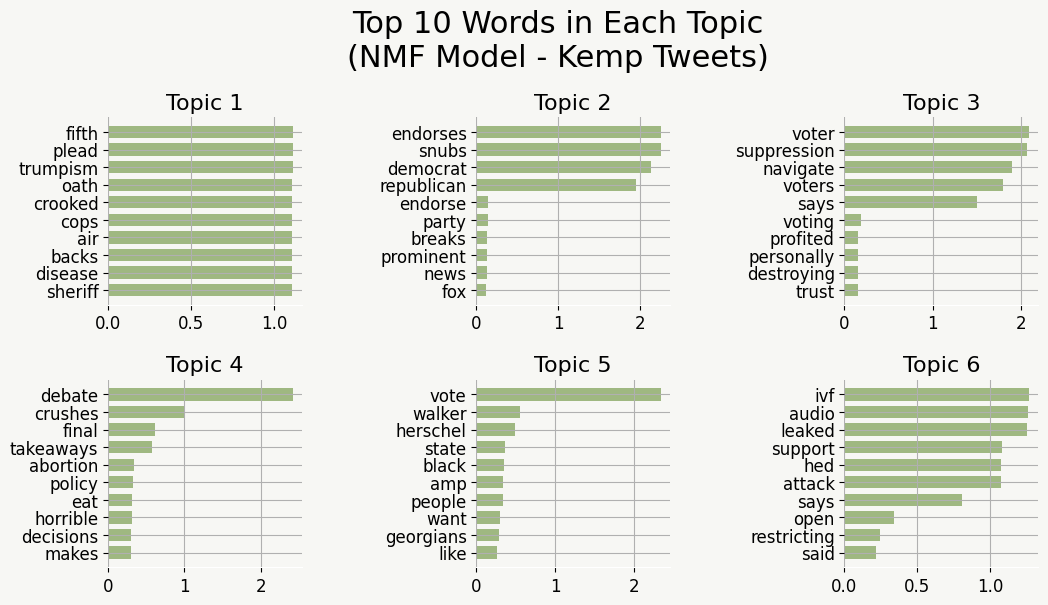

In [17]:
# Plot top 10 words of each topic - NMF Model - Kemp tweets (don't share x-axis)
plot_top_words(model=mod_nmf_kemp, 
               feature_names=tfidf_feature_names_kemp, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Kemp Tweets)',
               save_as='topic_mod_nmf_kemp_sharexNO',
               share_x=False)

##### **LDA**

In [18]:
# Instantiate the model
mod_lda_abrams = LatentDirichletAllocation(n_components=num_topics)
mod_lda_kemp = LatentDirichletAllocation(n_components=num_topics)

# Fit-Transform the model to the data
feat_lda_abrams = mod_lda_abrams.fit_transform(tf_abrams)
feat_lda_kemp = mod_lda_kemp.fit_transform(tf_kemp)

# See shape of features
print('LDA Features Shape - Abrams:', feat_lda_abrams.shape)
print('LDA Features Shape - Kemp:', feat_lda_kemp.shape)

LDA Features Shape - Abrams: (35119, 6)
LDA Features Shape - Kemp: (14664, 6)


<Figure size 640x480 with 0 Axes>

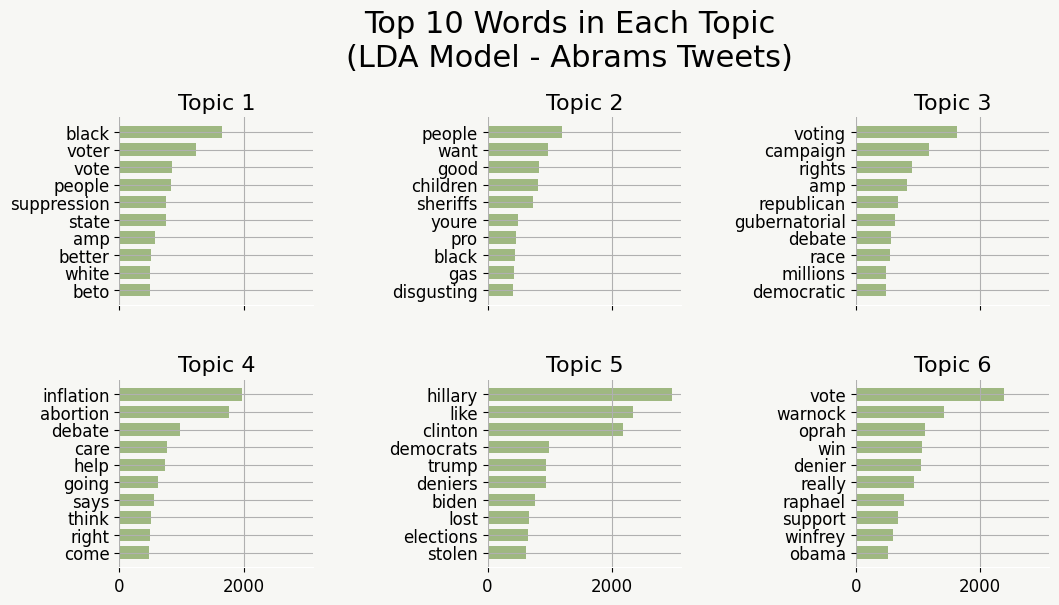

In [19]:
# Plot top 10 words of each topic - LDA Model - Abrams tweets (share x-axis)
plot_top_words(model=mod_lda_abrams, 
               feature_names=tf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Abrams Tweets)',
               save_as='topic_mod_lda_abrams_sharexYES',
               share_x=True)

<Figure size 640x480 with 0 Axes>

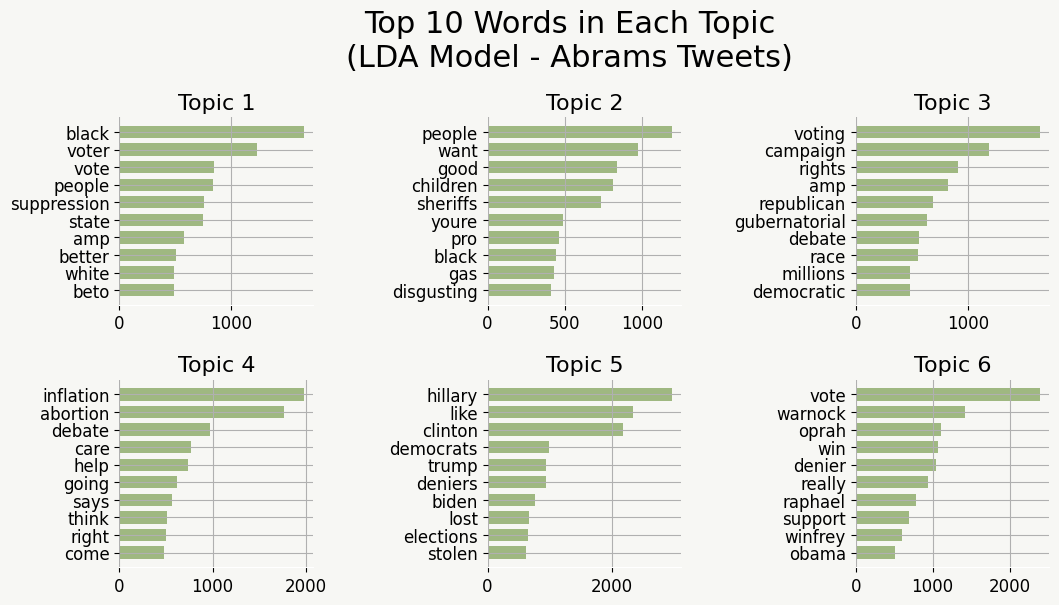

In [20]:
# Plot top 10 words of each topic - LDA Model - Abrams tweets (don't share x-axis)
plot_top_words(model=mod_lda_abrams, 
               feature_names=tf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Abrams Tweets)',
               save_as='topic_mod_lda_abrams_sharexNO',
               share_x=False)

<Figure size 640x480 with 0 Axes>

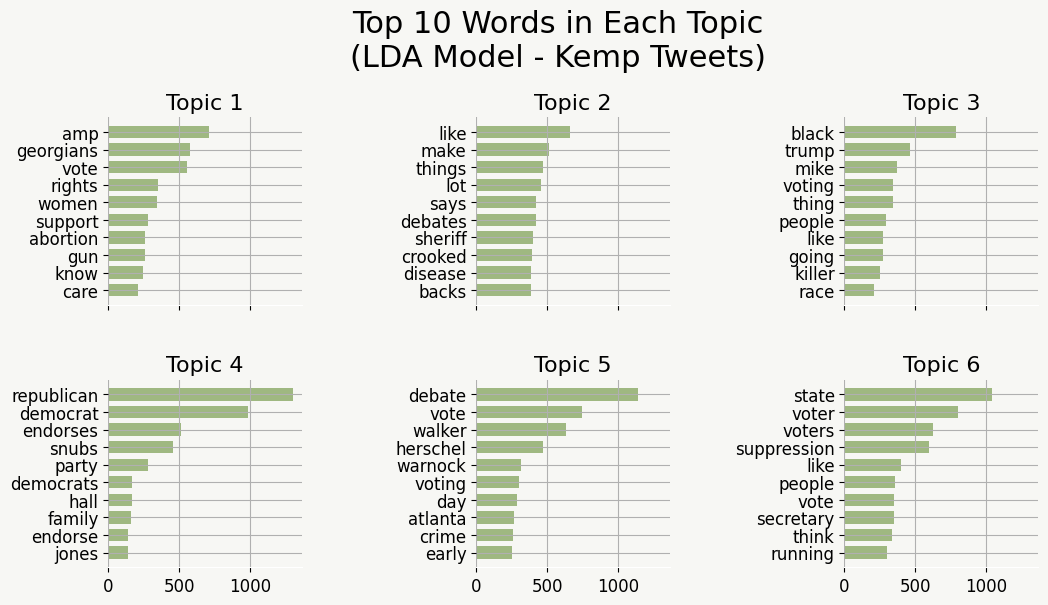

In [21]:
# Plot top 10 words of each topic - LDA Model - Kemp tweets (share x-axis)
plot_top_words(model=mod_lda_kemp, 
               feature_names=tf_feature_names_kemp,
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Kemp Tweets)',
               save_as='topic_mod_lda_kemp_sharexYES',
               share_x=True)

<Figure size 640x480 with 0 Axes>

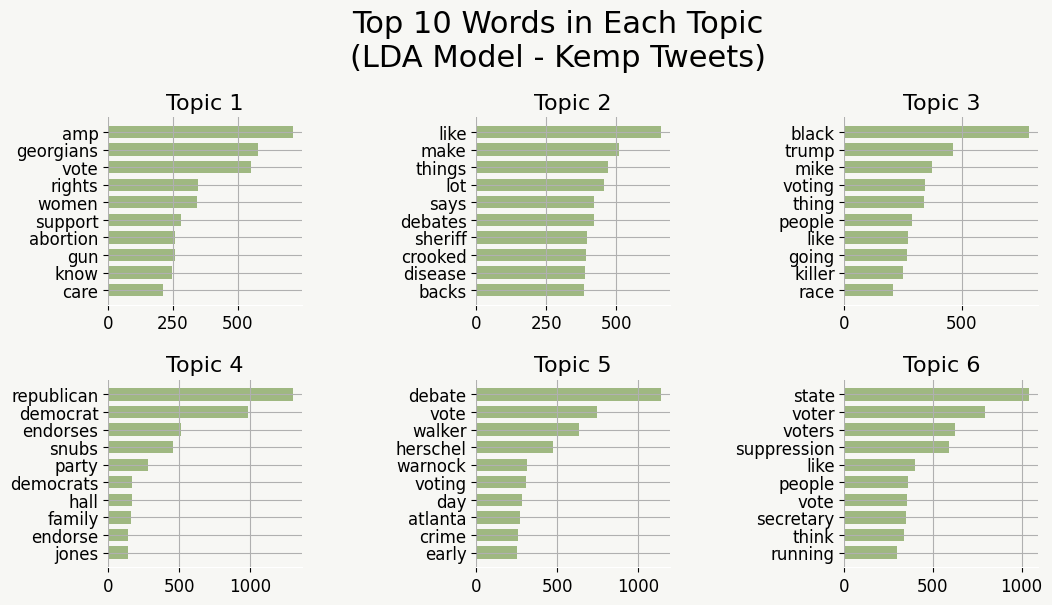

In [22]:
# Plot top 10 words of each topic - LDA Model - Kemp tweets (don't share x-axis)
plot_top_words(model=mod_lda_kemp, 
               feature_names=tf_feature_names_kemp,
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Kemp Tweets)',
               save_as='topic_mod_lda_kemp_sharexNO',
               share_x=False)